In [1]:
import collections
import multiprocessing
import threading
import random
import redis
import requests
import json
import sys
import time

import tornado.httpclient
import tornado.ioloop
import tornado.gen


rps = collections.defaultdict(list)
cpu_stats = []
lock = threading.Lock()
redis_cli = redis.StrictRedis('localhost', 63799)

SAMPLE_TIME = 5. # Seconds
RESOLUTION = 1.
ENDPOINT = 'http://api.io:8080/bounded/cpu'
loop = tornado.ioloop.IOLoop.current()
threads = []


@tornado.gen.coroutine
def main():
    print("Starting main...")
    client = tornado.httpclient.AsyncHTTPClient()
    requests_per_second = RESOLUTION
    while True:
        yield tornado.gen.sleep(1.)
        try:
            redis_cli.incr('client_requests')
            resp = yield client.fetch(ENDPOINT)
            if 200 <= resp.code < 300:
                redis_cli.incr('client_requests_succeeded')
                result = json.loads(resp.body)
                with lock:
                    cpu_stats.append(result)
            else:
                redis_cli.incr('client_requests_failed')
        except Exception as e:
            print("Caught exception", e)
            redis_cli.incr('client_requests_failed')
            

loop.call_later(0., main)


Starting main...


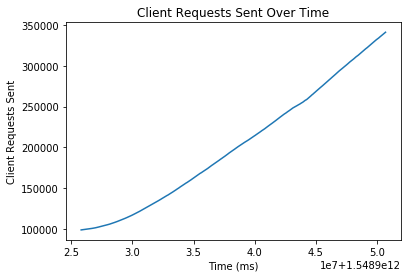

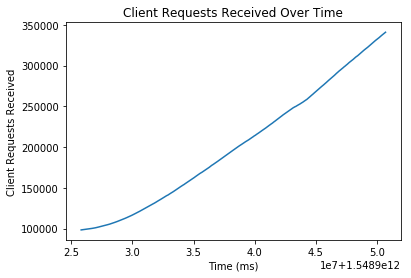

duration


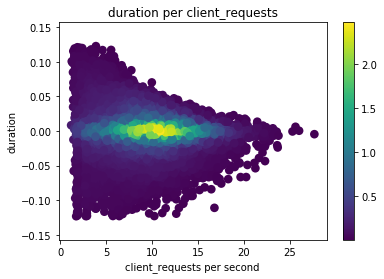

server_requests


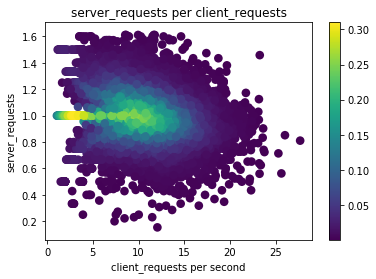

host.process.soft_interrupts


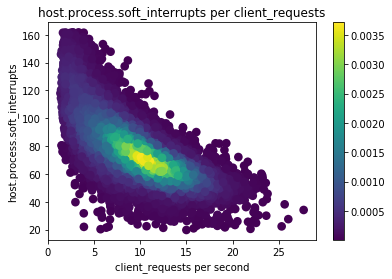

host.process.context_switches


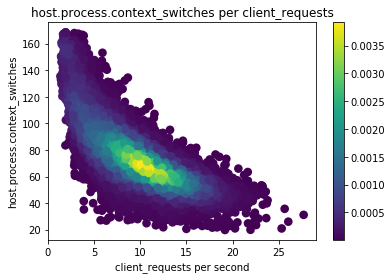

host.process.cpu.system


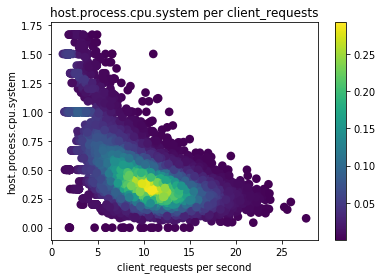

host.process.cpu.idle


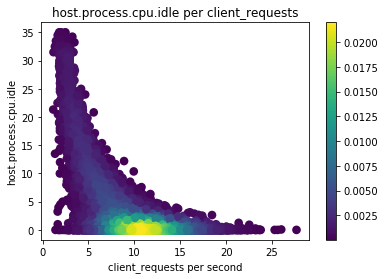

host.process.cpu.user


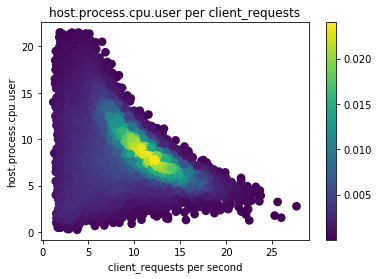

host.process.cpu.total


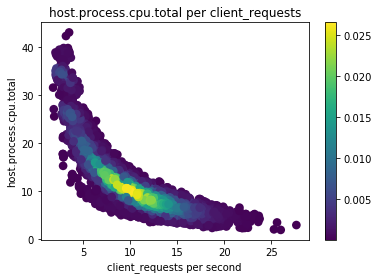

host.process.hard_interrupts


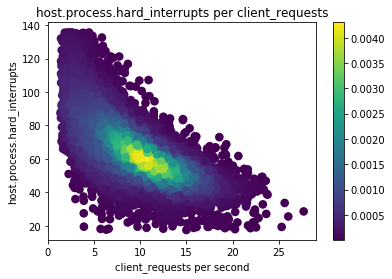

host.network.lo.RX-OK


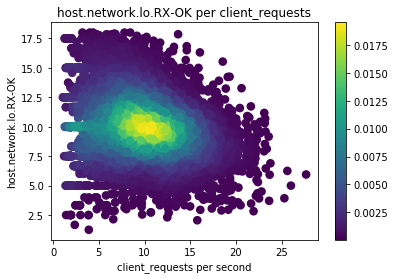

host.network.lo.TX-OK


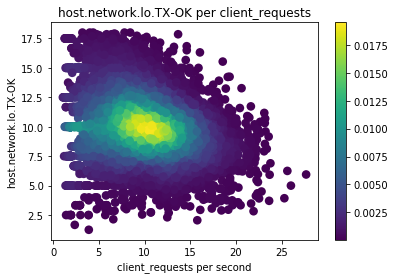

host.network.enp0s3.RX-OK


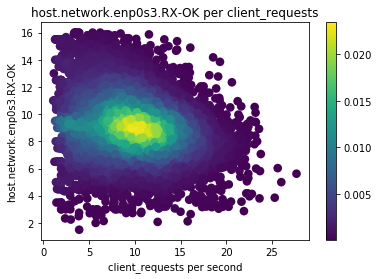

host.network.enp0s3.TX-OK


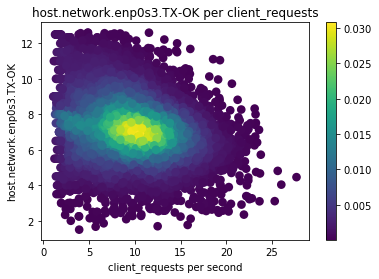

host.network.enp0s8.RX-OK


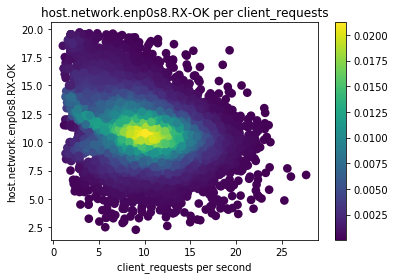

host.network.enp0s8.TX-OK


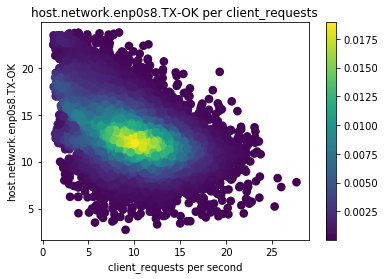

host.memory.Inactive:.value


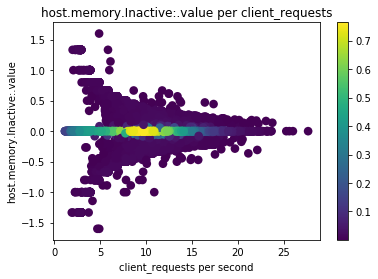

host.memory.Active:.value


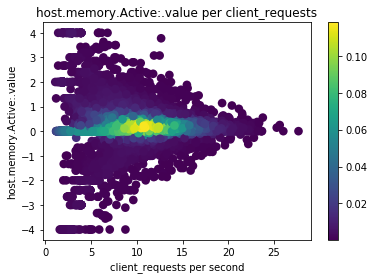

host.memory.Active(file):.value


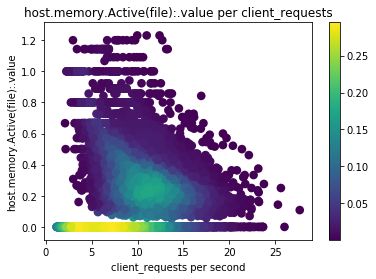

host.memory.Mapped:.value


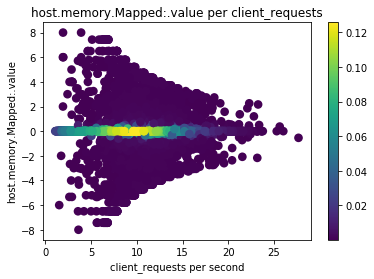

host.memory.Buffers:.value


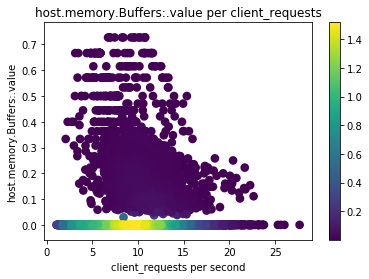

host.memory.MemAvailable:.value


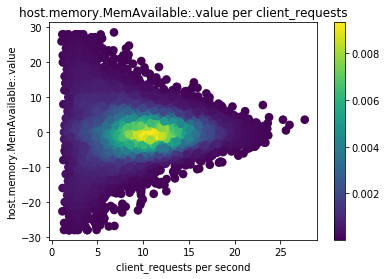

host.memory.SUnreclaim:.value


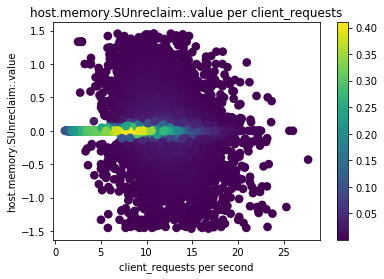

host.memory.Inactive(file):.value


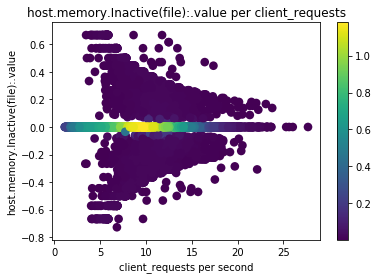

host.memory.PageTables:.value


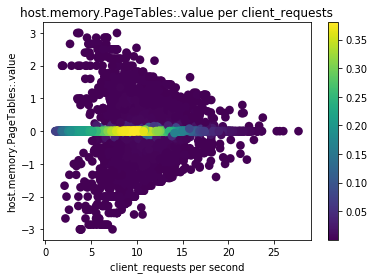

host.memory.Dirty:.value


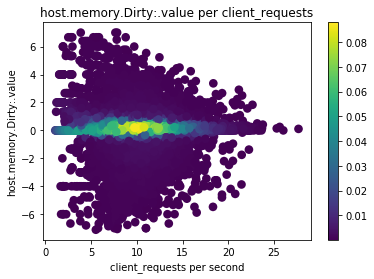

host.memory.MemFree:.value


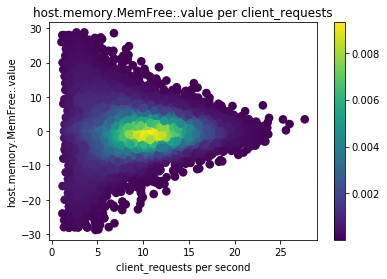

host.memory.Cached:.value


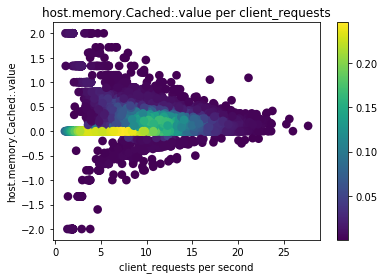

host.memory.SReclaimable:.value


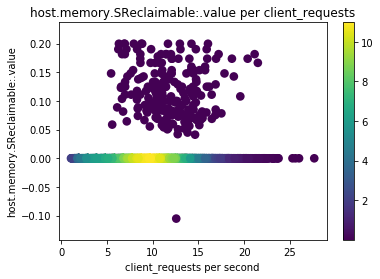

host.memory.AnonPages:.value


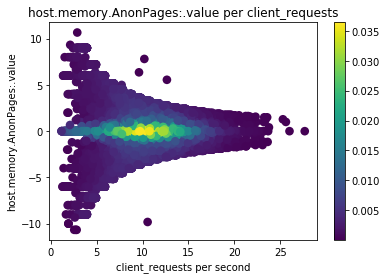

host.memory.Committed_AS:.value


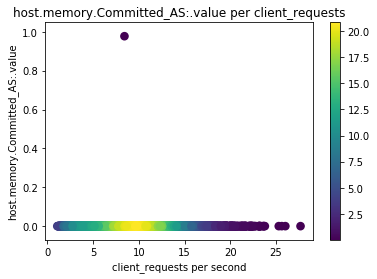

host.memory.Slab:.value


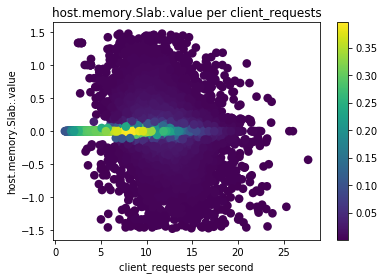

host.memory.Active(anon):.value


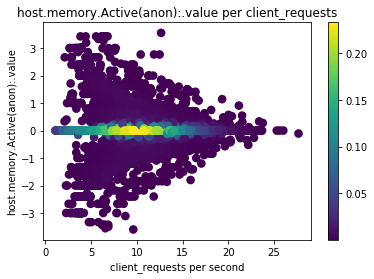

host.memory.KernelStack:.value


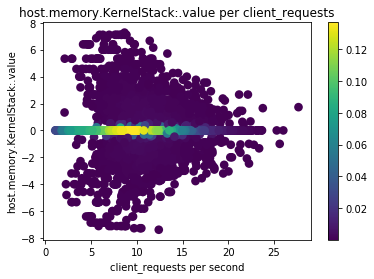

t_ms


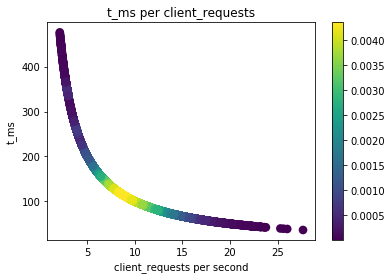

client_requests.failed


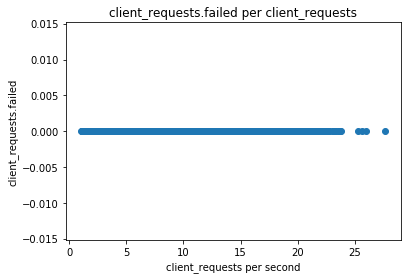

client_requests.sent


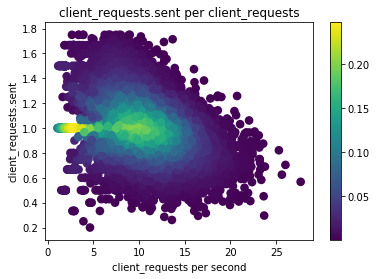

done


In [19]:
import pickle

with open('cpu2.pickle', 'rb') as fp:
    cpu_stats = pickle.loads(fp.read())


%matplotlib inline
import os.path
import json
import operator
import collections
import numpy
from scipy.stats import gaussian_kde
import scipy.linalg
import pickle
import random

import matplotlib.pyplot as plt


DO_NOT_PLOT = set([])# set(['host.process.cpu.io_wait', 'host.memory.Inactive(anon):.value', 'host.memory.Shmem:.value', 'host.memory.Writeback:.value'])

def derivative(stats, i, value_accessor, delta_accessor=None):            
    nxt_val = float(accessor(stats[i+1]))
    cur_val = float(accessor(stats[i]))
    
    delta = 1.
    if delta_accessor:
        nxt_del = float(delta_accessor(stats[i+1]))
        cur_del = float(delta_accessor(stats[i]))
        delta = (nxt_del - cur_del)
    
    return (nxt_val - cur_val) / delta


def accessor_lists(template):
    for k, v in template.items():
        if not isinstance(v, dict):
            yield [k], [operator.itemgetter(k)]
        else:
            for keys, accessor_list in accessor_lists(template[k]):
                yield [k] + keys, [operator.itemgetter(k)] + accessor_list


def flatten(nested_dict):
    for k, v in nested_dict.items():
        if not isinstance(v, dict):
            yield k, v
        else:
            for _k, _v in flatten(v):
                yield ".".join([k, _k]), _v 


def access(stat, accessor_list):
    v = stat
    for acc in accessor_list:
        v = acc(v)
    return v


def plot_points(title, x_label, y_label, points, heatmap=False):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    X, Y = points
    if heatmap:
        xy = numpy.vstack([X, Y])
        try:
            Z = gaussian_kde(xy)(xy)
            plt.scatter(X, Y, c=Z, s=75, edgecolor='')
            plt.colorbar()
        except scipy.linalg.LinAlgError as e:
            plt.scatter(X, Y)
    else:
        plt.plot(X, Y)
    plt.show()


def uninteresting(stats):
    mean, stddev = stats
    if stddev == 0.:
        return True
    return False


def remove_outliers(X, Y, distribution_statistics, stddevs=3):
    assert len(X) == len(Y)
    mean, stddev = distribution_statistics
    cleaned_X, cleaned_Y = [], []
    for x, y in zip(X, Y):
        if numpy.abs(y) > (numpy.abs(mean) + (stddevs*stddev)):
            continue
        cleaned_X.append(x)
        cleaned_Y.append(y)
    return cleaned_X, cleaned_Y


def get_stat_per_elapsed_requests_between(current_stat, next_stat, accessor_list):
    # Client requests over duration
    cur_elements = current_stat.get('elements')
    nxt_elements = next_stat.get('elements')

    nxt_x = next_stat.get('client_requests', {}).get('successful', 0) / nxt_elements
    cur_x = current_stat.get('client_requests', {}).get('successful', 0) / cur_elements
    elapsed_client_requests = float(nxt_x - cur_x)

    # Length of duration
    end_ms = float(next_stat.get('t_ms')) / float(nxt_elements)
    start_ms = float(current_stat.get('t_ms')) / float(cur_elements)
    elapsed_time_ms = float(end_ms - start_ms)

    # Client rps
    client_requests_per_second = 1000. * elapsed_client_requests / elapsed_time_ms
    if client_requests_per_second < 1:
        return None, None

    nxt_y = access(next_stat, accessor_list) / nxt_elements
    cur_y = access(current_stat, accessor_list) / cur_elements

    x = client_requests_per_second # Average client RPS over duration
    y = (nxt_y - cur_y) / elapsed_client_requests
    return x, y


def plot_stats(stats, derivative=False):
    template = stats[0]
    for labels, accessor_list in accessor_lists(template):
        label = ".".join(labels)
        if label in DO_NOT_PLOT:
            continue
        X, Y, points = [], [], []
        for i, stat in enumerate(stats):
            if i == len(stats) - 1:
                break
            x, y =  get_stat_per_elapsed_requests_between(stat, stats[i+1], accessor_list)
            if x is not None:
                X.append(x)
                Y.append(y)
            
        title = label + " vs t_ms"
        if derivative:
            title = label + " per client_requests"
        
        distribution_statistics = get_distribution_statistics(X, Y)
        if uninteresting(distribution_statistics):
            continue
            
        X, Y = remove_outliers(X, Y, distribution_statistics, stddevs=3)

        print(label)
        plot_points(title, "client_requests per second", ".".join(labels), (X, Y), heatmap=True)
        yield label, X, Y


def cast_ts_to_bin(ts, bin_size):
    return int(ts / bin_size) * bin_size
        

def bin_variance(X_requests_per_second, Y):
    _X, _Y = [], []
    min_samples = 100
    binned_by_rps = collections.defaultdict(list)
    for x, y in zip(X_requests_per_second, Y):
        binned_by_rps[cast_ts_to_bin(x, 1)].append(y)
    for x, points in sorted(binned_by_rps.items(), key=lambda o: o[0]):
        if len(points) < min_samples:
            continue
        _X.append(x), _Y.append(numpy.var(random.sample(points, min_samples)))
    return _X, _Y
        
    
def bin_stats(stats, ms_bin=100):
    binned = collections.defaultdict(dict)
    for stat in stats:
        bin = cast_ts_to_bin(stat.get('t_ms'), ms_bin)
        binned[bin] = add_stats(stat, binned[bin])
        binned[bin]['t_ms'] = bin
    return sorted([b for b in binned.values()], key=lambda o: o.get('t_ms'))


def get_distribution_statistics(X, Y):
    stddev = numpy.std(Y)
    mean = numpy.mean(Y)
    three_sigma = 2 * stddev
    return mean, stddev
        
        
def add_stats(a, b):
    c = {'elements': a.get('elements', 0) + b.get('elements', 0) + 1}
    for k, v in a.items():
        if isinstance(v, dict):
            c[k] = add_stats(a.get(k, {}), b.get(k, {}))
        elif isinstance(v, (int, float)):
            c[k] = a.get(k, 0.) + b.get(k, 0.)
        elif not isinstance(v, (str, bytes)) and v is not None:
            print(type(v))
    return c


def plot_client_requests_per_second_over_time(stats):
    X, Y, Y2 = [], [], []
    for stat in stats:
        t_ms = stat.get('t_ms')
        client_requests = stat.get('client_requests').get('sent')
        server_requests = stat.get('server_requests')
        X.append(t_ms)
        Y2.append(server_requests)
        Y.append(client_requests)
        
    plot_points("Client Requests Sent Over Time", "Time (ms)", "Client Requests Sent", (X, Y))
    plot_points("Client Requests Received Over Time", "Time (ms)", "Client Requests Received", (X, Y2))

    
plotted_labels = []
binned = bin_stats(cpu_stats[1:], ms_bin=1.)
plot_client_requests_per_second_over_time(binned)
to_analyze = collections.defaultdict(list)
for label, X, Y in plot_stats(binned, derivative=True):
    plotted_labels.append(label)
    X_sigma, Y_sigma = bin_variance(X, Y)
    to_analyze[label] = Y_sigma[0:17]
#   plot_points("Variance of " + label, "client_requests per second", "Variance", (X_sigma, Y_sigma))
    
print('done')


In [20]:
import pandas
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest


print('building columns for', len(binned), 'stats')

def build_columns(stats):
    columns = collections.defaultdict(list)
    for stat in stats:
        for k, v in flatten(stat):
            columns[k].append(v)
    return columns

#columns = to_analyze#build_columns(to_analyze)
            
for label, column in columns.items():
    print(label, len(column))
print('building dataframe')
dataframe = pandas.DataFrame(columns)
variable_types = {k: 'c' for k in columns.keys()}
print('instantiating algorithm')
ic_algorithm = IC(RobustRegressionTest)
print('executing search')
graph = ic_algorithm.search(dataframe, variable_types)
print('done')


building columns for 13508 stats
duration 17
server_requests 17
host.process.soft_interrupts 17
host.process.context_switches 17
host.process.cpu.system 17
host.process.cpu.idle 17
host.process.cpu.user 17
host.process.cpu.total 17
host.process.hard_interrupts 17
host.network.lo.RX-OK 17
host.network.lo.TX-OK 17
host.network.enp0s3.RX-OK 17
host.network.enp0s3.TX-OK 17
host.network.enp0s8.RX-OK 17
host.network.enp0s8.TX-OK 17
host.memory.Inactive:.value 17
host.memory.Active:.value 17
host.memory.Active(file):.value 17
host.memory.Mapped:.value 17
host.memory.Buffers:.value 17
host.memory.MemAvailable:.value 17
host.memory.SUnreclaim:.value 17
host.memory.Inactive(file):.value 17
host.memory.PageTables:.value 17
host.memory.Dirty:.value 17
host.memory.MemFree:.value 17
host.memory.Cached:.value 17
host.memory.SReclaimable:.value 17
host.memory.AnonPages:.value 17
host.memory.Committed_AS:.value 17
host.memory.Slab:.value 17
host.memory.Active(anon):.value 17
host.memory.KernelStack:.va

In [21]:
print('running')

for edge in graph.edges(data=True):
    print(edge)
print('done')



running
('duration', 'host.process.cpu.system', {'marked': False, 'arrows': ['host.process.cpu.system']})
('host.process.soft_interrupts', 'host.process.hard_interrupts', {'marked': False, 'arrows': []})
('host.process.context_switches', 'host.network.enp0s8.TX-OK', {'marked': False, 'arrows': []})
('host.process.cpu.system', 'host.memory.MemAvailable:.value', {'marked': False, 'arrows': ['host.process.cpu.system']})
('host.process.cpu.idle', 'host.memory.Cached:.value', {'marked': False, 'arrows': ['host.memory.Cached:.value']})
('host.process.cpu.idle', 't_ms', {'marked': False, 'arrows': ['t_ms']})
('host.network.lo.RX-OK', 'host.network.enp0s8.RX-OK', {'marked': False, 'arrows': []})
('host.network.lo.TX-OK', 'host.network.enp0s3.TX-OK', {'marked': False, 'arrows': ['host.network.enp0s3.TX-OK']})
('host.network.enp0s3.TX-OK', 'client_requests.sent', {'marked': False, 'arrows': ['host.network.enp0s3.TX-OK', 'client_requests.sent']})
('host.memory.Inactive:.value', 'host.memory.Cache

### Bottleneck Definition

A _bottleneck_ occurs when the capacity of an application is limited by a single component.

An application is limited when sending client requests at a higher rate does not result in requests being processed at a higher rate.

If the rate of client requests into a system is $ C_{in} $ and the rate of requests processed by that system is $ S_{out} $; then a bottleneck occurs when $ C_{in} > S_{out} \forall C_{in} > C_{critical} $ Where $ C_{critical} $ is the _critical_ rate of requests at which we reach a bottleneck.

A resource _causes_ a bottleneck when
  - there is a bottleneck
  - that resources allocation has reached its maximum allowed value

### Maximum Allocation Definition

A resource has reached _a_ maximum allocation, $ A_{max} $ when 
  - it has a known maximum quantity and its measured value is equal to that value within some episilon or
  - the (absolute value of the) rate of change of allocation with respect to incoming client requests reaches 0 from some positive value.
  
Some resources are typically measured as parts of a whole (e.g. user vs system CPU). Let $ \textbf{R} = \{R_i, R_{i+1}, ..., R{n}\} $ 
where $ n \in \mathbb{N} $ be a vector of weights of each component resource.

This type of resource is at a maximum when $ \sum_N{R_i} = 1 $.

### Observations

The variance of metrics with respect to incoming client requests gets very high when there is a bottleneck. Client requests vary randomly about that point, and so do resource allocations.

Validation process:

  - Create a network bound process
    - figure out the total bandwidth on the interface
    - find the duration of a request
    - given maximum overlap, the total throughput of the request should add to the interface bandwidth
    - request size = total bandwidth (mb/s) / bottleneck rate (rps)?
    - ensure it is not memory bound
  - Collect metrics
    - create a processes sending 1 rps/s
    - add 1 additional process every 5 minutes
    - stop at 100 processes
    - write the metrics to disk each time we add a new process
  - Save as a .pickle file (e.g. network.pickle)
  - Verify that network i/o has increasing variance
  
  - Create a CPU bound process
  - Run fibonacci sequences
  - verify the same
  
  - Create a memory bound process
  - verify the same
    
# Explanation

As we approach $ C_{critical} $ 
  - the total resources _per_ request varies increasingly
  - when we hit a maximum allocation of resources $ A_{max} $ the number of client requests can still vary while the resource allocation stays constant. When there are fewer client RPS the allocation can change to something < $ A_{max} $ 
  
 Investigate whether or not we can get CPU variance to increase while bottlenecking at another resource.

In [7]:
%matplotlib inline

import collections
import random
import pickle
import numpy
import pandas
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

import matplotlib.pyplot as plt


def flatten(nested_dict):
    for k, v in nested_dict.items():
        if not isinstance(v, dict):
            yield k, v
        else:
            for _k, _v in flatten(v):
                yield ".".join([k, _k]), _v 
                

def uninteresting(Y):
    stddev = numpy.std(Y)
    mean = numpy.mean(Y)
    if stddev < 10e-12:
        return True
    return False
            
    
def assert_nonnegative(label, Y):
    for value in Y:
        assert value >= 0, "Found non-negative value in {}".format(label)
    return True
    
print('loading cpu2 data')
with open('memory.pickle', 'rb') as fp:
    cpu_stats = pickle.loads(fp.read())
print('loaded')
    
print('building columns...')
columns = collections.defaultdict(list)
for stat in cpu_stats:
    for label, stat in flatten(stat):
        if isinstance(stat, (bytes, str)):
            break
        columns[label].append(stat)
print('built')

# Filter those stats with stddev=0
print('filtering columns...')
columns = {label: Y for label, Y in columns.items() 
           if not uninteresting(Y) and assert_nonnegative(label, Y)}
print('filtered.')

print('')
for key in columns.keys():
    print(key, type(columns[key][0]), random.choice(columns[key]), len(columns[key]))

variable_types = {label: 'c' for label in columns.keys()}
    
variable_types = {'duration': 'c',
                 'server_requests': 'd',
                 'client_requests.sent': 'd',
                 'client_requests.successful': 'd',
                 'host.process.context_switches': 'd',
                 'host.process.cpu.user': 'd',
                 'host.process.hard_interrupts': 'd',
                 'host.network.lo.RX-OK': 'd',
                 'host.network.enp0s3.RX-OK': 'd',
                 'host.network.enp0s8.RX-OK': 'd',
                 'host.memory.Inactive:.value': 'd'}

dataframe = pandas.DataFrame(columns)
    
print('instantiating algorithm')
ic_algorithm = IC(RobustRegressionTest)
print('executing search')
graph = ic_algorithm.search(dataframe, variable_types)
print('done')


loading cpu2 data
loaded
building columns...
built
filtering columns...
filtered.

duration <class 'float'> 0.0035262107849121094 3793
server_requests <class 'float'> 24378.0 3793
host.process.context_switches <class 'int'> 9170993 3793
host.process.soft_interrupts <class 'int'> 17066819 3793
host.process.cpu.io_wait <class 'int'> 478 3793
host.process.cpu.system <class 'int'> 145066 3793
host.process.cpu.idle <class 'int'> 2699287 3793
host.process.cpu.user <class 'int'> 129703 3793
host.process.cpu.total <class 'float'> 2793686.0 3793
host.process.hard_interrupts <class 'int'> 10056044 3793
host.network.lo.RX-OK <class 'int'> 557000 3793
host.network.lo.TX-OK <class 'int'> 275053 3793
host.network.enp0s3.RX-OK <class 'int'> 392662 3793
host.network.enp0s3.TX-OK <class 'int'> 268782 3793
host.network.enp0s8.RX-OK <class 'int'> 17943568 3793
host.network.enp0s8.TX-OK <class 'int'> 5616762 3793
host.memory.Inactive:.value <class 'int'> 333936 3786


ValueError: arrays must all be same length

using spring layout


/Users/akelleher/.virtualenvs/bottlenecks/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/akelleher/.virtualenvs/bottlenecks/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/akelleher/.virtualenvs/bottlenecks/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


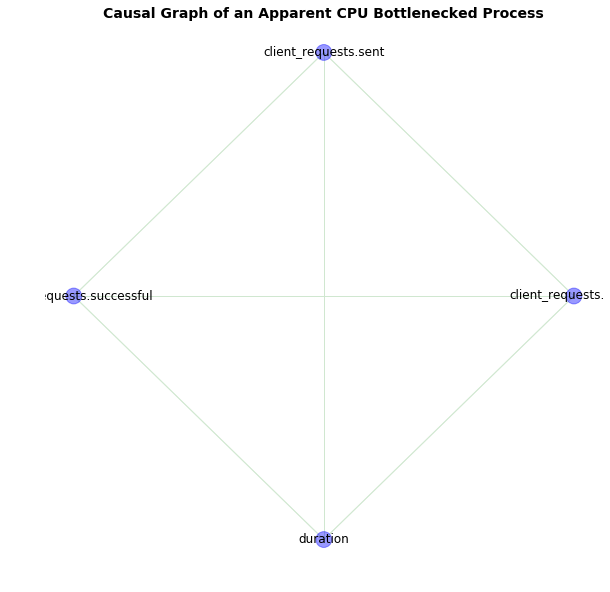

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

THICK = 10.
THIN = 1.
BIG = 20
SMALL = 5

edgewidth = []
sizes = {}
for edge in graph.edges(data=True):
    u, v, edgeinfo = edge
    if edgeinfo.get('marked'):
        edgewidth.append(THICK)
        sizes[u] = BIG
        sizes[v] = BIG
    else:
        edgewidth.append(THIN)

for node in graph.nodes():
    if node not in sizes:
        sizes[node] = SMALL
    
try:
    pos = nx.nx_agraph.graphviz_layout(graph)
except:
    print('using spring layout')
    #pos = nx.draw_networkx(graph, arrows=True)
    pos = nx.kamada_kawai_layout(graph)#, iterations=10)

plt.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(graph, pos, alpha=0.3, width=edgewidth, edge_color='g', arrows=True, arrowstyle='-|>', arrowsize=100)
nodesize = [sizes[v] * 50 for v in graph]
nx.draw_networkx_nodes(graph, pos, node_size=nodesize, node_color='b', alpha=.4, arrows=True, arrowstyle='-|>', arrowsize=100)
nx.draw_networkx_edges(graph, pos, alpha=0.4, node_size=0, width=1, edge_color='w', arrows=True, arrowstyle='-|>', arrowsize=100)
nx.draw_networkx_labels(graph, pos, fontsize=14)
font = {'fontname': 'Helvetica',
        'color': 'k',
        'fontweight': 'bold',
        'fontsize': 14}
plt.title("Causal Graph of an Apparent CPU Bottlenecked Process", font)

# change font and write text (using data coordinates)
font = {'fontname': 'Helvetica',
        'color': 'r',
        'fontweight': 'bold',
        'fontsize': 14}
"""
plt.text(0.5, 0.97, "edge width = # games played",
         horizontalalignment='center',
         transform=plt.gca().transAxes)
plt.text(0.5, 0.94, "node size = # games won",
         horizontalalignment='center',
         transform=plt.gca().transAxes)
"""

plt.axis('off')
plt.show()